In [2]:
import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf

In [35]:
nlp = spacy.load('en_core_web_sm')
dataset = pd.read_csv('/content/Emotion_final.csv')
dataset.sample(5)

,Text,Emotion
10384,i feel dirty if i dont,sadness
18002,i feel like a faithful servant,love
28403,i ever feel ugly or ashamed of my body,sadness
5275,im down to blogging again simply because im fe...,anger
23162,i feel like my songs are pretty lame and eleme...,sadness


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19943 entries, 0 to 19942
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     19943 non-null  object
 1   Emotion  19942 non-null  object
dtypes: object(2)
memory usage: 311.7+ KB


In [5]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input

longest_input = get_longest_text(dataset['Text'])
longest_input

66

In [6]:
data_emb = np.zeros((len(dataset), longest_input, 96))

for i, text in enumerate(tqdm(nlp.pipe(dataset['Text']), total=len(dataset)), 0):
    for j, token in enumerate(text, 0):
        if j <= 65:
            data_emb[i, j] = token.vector

  0%|          | 0/19943 [00:00<?, ?it/s]

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoder = encoder.fit_transform(dataset['Emotion'])
y = to_categorical(y_encoder)
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [15]:
len(encoder.classes_)

7

### Building a NN as a classifier

In [28]:
import keras
# Prepare the network
inputs = keras.layers.Input((longest_input, 96))
reshaped = keras.layers.Reshape((longest_input, 96, 1))(inputs)

filters = [2, 3, 4]

# Define convolution layers
conv_1 = keras.layers.Conv2D(100, (filters[0], 96), activation='relu')(reshaped)
conv_2 = keras.layers.Conv2D(100, (filters[1], 96), activation='relu')(reshaped)
conv_3 = keras.layers.Conv2D(100, (filters[2], 96), activation='relu')(reshaped)

# Define pooling layers
pool_1 = keras.layers.MaxPooling2D((longest_input - filters[0] +1, 1))(conv_1)
pool_2 = keras.layers.MaxPooling2D((longest_input - filters[1] +1, 1))(conv_2)
pool_3 = keras.layers.MaxPooling2D((longest_input - filters[2] +1, 1))(conv_3)

concatenation = keras.layers.concatenate([pool_1, pool_2, pool_3])
flattened = keras.layers.Flatten()(concatenation)
dense = keras.layers.Dense(100, activation='relu')(flattened)
clf = keras.layers.Dense(len(encoder.classes_), activation='softmax')(dense) #output

In [29]:
# Create the model
model = tf.keras.models.Model(inputs, clf)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 66, 96)]     0           []                               
                                                                                                  
 reshape_4 (Reshape)            (None, 66, 96, 1)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 65, 1, 100)   19300       ['reshape_4[0][0]']              
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 1, 100)   28900       ['reshape_4[0][0]']              
                                                                                            

In [19]:
!pip install pydot graphviz

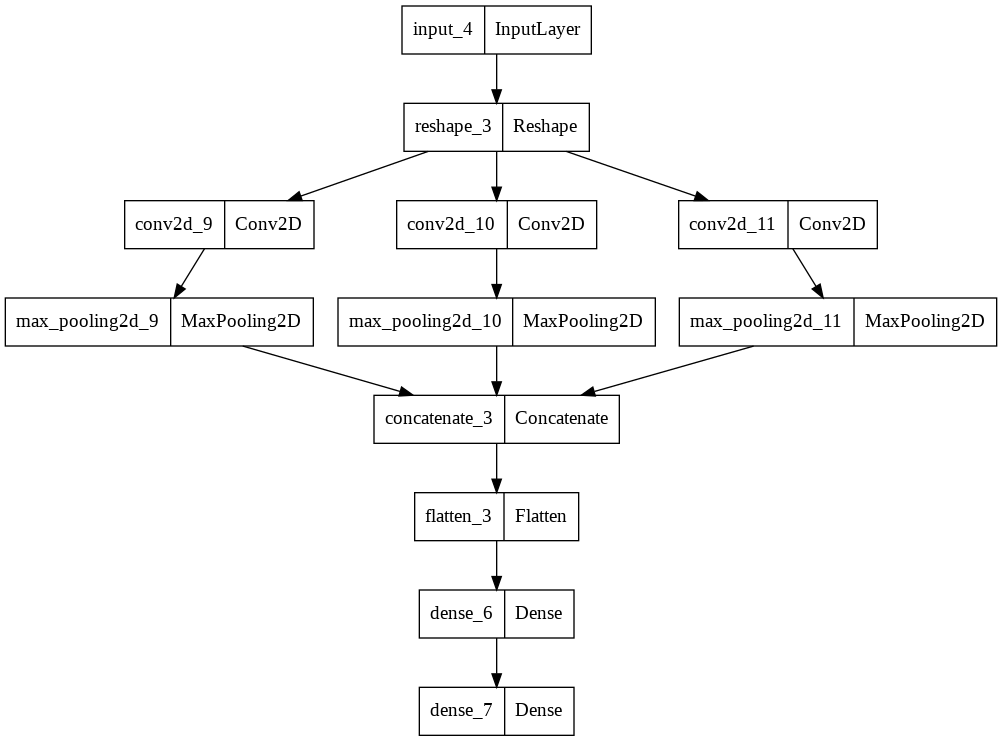

In [27]:
tf.keras.utils.plot_model(model, show_shapes=False, 
                          show_layer_names=True, rankdir='TB',
                          expand_nested=False, dpi=96)

### Train the model

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_emb, y, test_size=0.3)
model.fit(X_train, y_train, epochs=23)

Epoch 1/23
437/437 [==============================] - 14s 31ms/step - loss: 1.5433 - acc: 0.3769
Epoch 2/23
437/437 [==============================] - 13s 30ms/step - loss: 1.3209 - acc: 0.4764
Epoch 3/23
437/437 [==============================] - 13s 31ms/step - loss: 1.1492 - acc: 0.5516
Epoch 4/23
437/437 [==============================] - 13s 30ms/step - loss: 0.9551 - acc: 0.6372
Epoch 5/23
437/437 [==============================] - 13s 30ms/step - loss: 0.7771 - acc: 0.7107
Epoch 6/23
437/437 [==============================] - 13s 30ms/step - loss: 0.6090 - acc: 0.7817
Epoch 7/23
437/437 [==============================] - 13s 30ms/step - loss: 0.4627 - acc: 0.8349
Epoch 8/23
437/437 [==============================] - 13s 30ms/step - loss: 0.3445 - acc: 0.8771
Epoch 9/23
437/437 [==============================] - 13s 30ms/step - loss: 0.2224 - acc: 0.9294
Epoch 10/23
437/437 [==============================] - 14s 32ms/step - loss: 0.2300 - acc: 0.9188
Epoch 11/23
437/437 [========

In [32]:
# Model evaluation
model.evaluate(X_test, y_test)

187/187 [==============================] - 3s 14ms/step - loss: 2.8103 - acc: 0.5481


[2.810325860977173, 0.5480527877807617]

In [64]:
def emotion_prediction(text):
    text_vec = np.zeros((1, longest_input, 96))
    for i, token in enumerate(nlp(text)):
        if i <= longest_input:
            text_vec[0, i] = token.vector

    prediction = np.argmax(model.predict(text_vec))
    return encoder.classes_[prediction]

In [65]:
print(emotion_prediction("I feel sad about what is happening in occupied Palestineee🇸🇩"))
print(emotion_prediction("I'm very happy for hearnign that"))

sadness
happy
